# AirBnb Data Project
This project consists of the following:
1) Downloading listing data
2) Cleaning the raw data
3) Inserting the cleaned data into a SQL database
4) Exploring the data via SQL

## Setup

This Airbnb data was retrieved from Inside Airbnb https://insideairbnb.com/get-the-data/

It includes a variety of paramaters regarding listings in New York City for March 2025.

In [73]:
#imports
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
#importing in the air bnb data, which was scrapped for nyc march 2025
datapath = 'data/'
dirty_data = 'nyc_airbnb_listings_march.csv'

#analyzing the different columns
dirty_df = pd.read_csv(datapath+dirty_data)
dirty_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37434 entries, 0 to 37433
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            37434 non-null  float64
 1   listing_url                                   37434 non-null  object 
 2   scrape_id                                     37434 non-null  float64
 3   last_scraped                                  37434 non-null  object 
 4   source                                        37434 non-null  object 
 5   name                                          37432 non-null  object 
 6   description                                   36441 non-null  object 
 7   neighborhood_overview                         20224 non-null  object 
 8   picture_url                                   37433 non-null  object 
 9   host_id                                       37434 non-null 

## Data Cleaning

Going through the dataset to find relevant parameters, clean data, and resolving any issues before further processing.

In [75]:
#deciding which columns to keep, based on a subjective analysis of what information is useful
kept_indices= [0,9,18,26,28,29,30,31,33,35,37,38,40,56,65]

#illustrating which columns where kept vs dropped
all_columns = dirty_df.columns.tolist()
kept_columns = [all_columns[i] for i in kept_indices]
dropped_columns = [col for col in all_columns if col not in kept_columns]

comparison_df = pd.DataFrame({
    'Kept Columns' : pd.Series(kept_columns),
    'Dropped Columns' : pd.Series(dropped_columns)
})

comparison_df.fillna('', inplace=True)
comparison_df

,Kept Columns,Dropped Columns
0,id,listing_url
1,host_id,scrape_id
2,host_is_superhost,last_scraped
3,host_identity_verified,source
4,neighbourhood_cleansed,name
...,...,...
59,,calculated_host_listings_count
60,,calculated_host_listings_count_entire_homes
61,,calculated_host_listings_count_private_rooms
62,,calculated_host_listings_count_shared_rooms


In [76]:
#filter the df
df_filtered  = dirty_df.iloc[:,kept_indices]
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37434 entries, 0 to 37433
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            37434 non-null  float64
 1   host_id                       37434 non-null  int64  
 2   host_is_superhost             36994 non-null  object 
 3   host_identity_verified        37396 non-null  object 
 4   neighbourhood_cleansed        37434 non-null  object 
 5   neighbourhood_group_cleansed  37434 non-null  object 
 6   latitude                      37434 non-null  float64
 7   longitude                     37434 non-null  float64
 8   room_type                     37434 non-null  object 
 9   bathrooms                     22503 non-null  float64
 10  bedrooms                      31523 non-null  float64
 11  beds                          22352 non-null  float64
 12  price                         22308 non-null  object 
 13  n

In [77]:
df_filtered.head()

,id,host_id,host_is_superhost,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,room_type,bathrooms,bedrooms,beds,price,number_of_reviews,review_scores_rating
0,36121.0,62165,f,t,Prospect Heights,Brooklyn,40.673760,-73.966110,Private room,1.0,1.0,1.0,$200.00,9,4.88
1,36647.0,157798,f,t,East Harlem,Manhattan,40.792454,-73.940742,Private room,1.0,1.0,1.0,$82.00,102,4.77
2,38663.0,165789,f,t,Boerum Hill,Brooklyn,40.684420,-73.980680,Private room,2.5,5.0,5.0,$765.00,43,4.70
3,38833.0,166532,t,t,Harlem,Manhattan,40.818058,-73.946671,Entire home/apt,1.0,1.0,1.0,$139.00,241,4.85
4,39282.0,168525,t,t,Williamsburg,Brooklyn,40.710651,-73.950874,Private room,1.0,1.0,1.0,$130.00,274,4.82


In [78]:
#clean the dataframe
df_filtered = df_filtered.dropna(subset=['price','bathrooms','bedrooms','beds'])

df_filtered['host_is_superhost'] = df_filtered['host_is_superhost'].fillna('f')
df_filtered['review_scores_rating'] = df_filtered['review_scores_rating'] .fillna(0)

df_filtered['price'] = df_filtered['price'].replace('[\$,]','',regex=True).astype(float)

#getting rid of outliers
quantiles = (
    df_filtered.groupby('neighbourhood_group_cleansed')['price']
    .quantile(0.95)
    .rename('price_cap')
    .reset_index()
)

df_filtered = df_filtered.merge(quantiles, on='neighbourhood_group_cleansed')
df_filtered = df_filtered[df_filtered['price'] <= df_filtered['price_cap']]
df_filtered = df_filtered.drop(columns='price_cap')

df_cleaned = df_filtered.copy()
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21079 entries, 0 to 22174
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            21079 non-null  float64
 1   host_id                       21079 non-null  int64  
 2   host_is_superhost             21079 non-null  object 
 3   host_identity_verified        21061 non-null  object 
 4   neighbourhood_cleansed        21079 non-null  object 
 5   neighbourhood_group_cleansed  21079 non-null  object 
 6   latitude                      21079 non-null  float64
 7   longitude                     21079 non-null  float64
 8   room_type                     21079 non-null  object 
 9   bathrooms                     21079 non-null  float64
 10  bedrooms                      21079 non-null  float64
 11  beds                          21079 non-null  float64
 12  price                         21079 non-null  float64
 13  number

<>:7: SyntaxWarning: invalid escape sequence '\$'
<>:7: SyntaxWarning: invalid escape sequence '\$'
C:\Users\erict\AppData\Local\Temp\ipykernel_20548\2999549729.py:7: SyntaxWarning: invalid escape sequence '\$'
  df_filtered['price'] = df_filtered['price'].replace('[\$,]','',regex=True).astype(float)


## SQL Database

Creating a SQLite database, where all filtered and cleaned listing data will be stored alongside several tables that query for insightful information.

In [79]:
#establish connection
conn = sqlite3.connect('db/airbnb.db')

In [80]:
#write dataframe to the database
def write_df(df,name):
    df.to_sql(name, conn, if_exists='replace', index=False)

In [81]:
#display query function
def run_query(query):
    return pd.read_sql(query, conn)

In [82]:
#publish our "main" dataframe
write_df(df_cleaned,"listings")

## Data Exploration

Creating several queries to explore the data, mostly revolving around pricing baased on different factors.

In [83]:
borough_pricing = run_query(
"""
SELECT neighbourhood_group_cleansed, AVG(price) AS avg_price,
RANK() OVER (ORDER BY AVG(price) DESC) as borough_rank
FROM listings
GROUP BY neighbourhood_group_cleansed
ORDER BY avg_price DESC
""")

write_df(borough_pricing,'borough_pricing')
borough_pricing

,neighbourhood_group_cleansed,avg_price,borough_rank
0,Manhattan,219.152445,1
1,Brooklyn,138.354190,2
2,Queens,108.176997,3
3,Staten Island,106.123746,4
4,Bronx,96.213210,5


In [84]:
neighborhood_pricing = run_query(
"""
SELECT listings.neighbourhood_group_cleansed, neighbourhood_cleansed, AVG(price) AS avg_price,
RANK() OVER (PARTITION BY listings.neighbourhood_group_cleansed ORDER BY  AVG(price) DESC) AS neighborhood_rank,
borough_rank
FROM listings
JOIN borough_pricing 
ON listings.neighbourhood_group_cleansed = borough_pricing.neighbourhood_group_cleansed
GROUP BY listings.neighbourhood_group_cleansed, neighbourhood_cleansed
ORDER BY borough_rank;
""")

write_df(neighborhood_pricing,'neighborhood_pricing')
neighborhood_pricing

,neighbourhood_group_cleansed,neighbourhood_cleansed,avg_price,neighborhood_rank,borough_rank
0,Manhattan,NoHo,400.250000,1,1
1,Manhattan,Battery Park City,365.000000,2,1
2,Manhattan,Tribeca,363.741573,3,1
3,Manhattan,Theater District,323.799213,4,1
4,Manhattan,West Village,303.817308,5,1
...,...,...,...,...,...
215,Bronx,Morris Park,74.419355,45,5
216,Bronx,Bronxdale,72.909091,46,5
217,Bronx,Highbridge,70.187500,47,5
218,Bronx,Hunts Point,67.437500,48,5


In [85]:
most_expensive_neighborhood_by_borough = run_query(
"""
SELECT *
FROM neighborhood_pricing 
WHERE neighborhood_rank=1
""")
write_df(most_expensive_neighborhood_by_borough,'most_expensive_neighborhood_by_borough')
most_expensive_neighborhood_by_borough

,neighbourhood_group_cleansed,neighbourhood_cleansed,avg_price,neighborhood_rank,borough_rank
0,Manhattan,NoHo,400.250000,1,1
1,Brooklyn,DUMBO,272.470588,1,2
2,Queens,Neponsit,284.000000,1,3
3,Staten Island,Willowbrook,210.000000,1,4
4,Bronx,Spuyten Duyvil,154.750000,1,5


In [86]:
price_by_rating = run_query(
"""
SELECT price, review_scores_rating
FROM listings 
WHERE review_scores_rating != 0
ORDER BY price DESC
""")
write_df(price_by_rating,'price_by_rating')
price_by_rating

,price,review_scores_rating
0,729.0,4.40
1,729.0,4.91
2,729.0,5.00
3,727.0,4.69
4,725.0,5.00
...,...,...
14839,23.0,4.89
14840,22.0,4.36
14841,20.0,4.78
14842,19.0,4.35


In [87]:
price_by_rating_by_neighborhood = run_query(
"""
SELECT neighbourhood_group_cleansed, price, review_scores_rating
FROM listings 
WHERE review_scores_rating != 0
ORDER BY neighbourhood_group_cleansed DESC, price DESC
""")
write_df(price_by_rating_by_neighborhood,'price_by_rating_by_neighborhood')
price_by_rating_by_neighborhood

,neighbourhood_group_cleansed,price,review_scores_rating
0,Staten Island,268.0,5.00
1,Staten Island,266.0,5.00
2,Staten Island,255.0,5.00
3,Staten Island,250.0,4.65
4,Staten Island,240.0,4.73
...,...,...,...
14839,Bronx,33.0,4.94
14840,Bronx,33.0,5.00
14841,Bronx,32.0,4.80
14842,Bronx,30.0,5.00


In [88]:
superhost_impact = run_query(
"""
SELECT host_is_superhost, avg(price) as avg_price
FROM listings
GROUP BY host_is_superhost
"""
)
write_df(superhost_impact,'superhost_impact')
superhost_impact

,host_is_superhost,avg_price
0,f,174.392026
1,t,152.874492


In [89]:
superhost_neighborhood_impact = run_query(
"""
SELECT neighbourhood_group_cleansed, host_is_superhost, avg(price) as avg_price
FROM listings
GROUP BY neighbourhood_group_cleansed,host_is_superhost
"""
)
write_df(superhost_neighborhood_impact,'superhost_neighborhood_impact')
superhost_neighborhood_impact

,neighbourhood_group_cleansed,host_is_superhost,avg_price
0,Bronx,f,98.691814
1,Bronx,t,89.779167
2,Brooklyn,f,137.922706
3,Brooklyn,t,139.253712
4,Manhattan,f,226.096416
5,Manhattan,t,195.969300
6,Queens,f,107.008215
7,Queens,t,110.611217
8,Staten Island,f,104.338542
9,Staten Island,t,109.327103


In [90]:
#checking which tables have been published

run_query("SELECT name FROM sqlite_master WHERE type='table';")

,name
0,listings
1,borough_pricing
2,neighborhood_pricing
3,most_expensive_neighborhood_by_borough
4,price_by_rating
5,price_by_rating_by_neighborhood
6,superhost_impact
7,superhost_neighborhood_impact


## Visualizations

Finally, displaying several visuals to illustrate the insights gained from our various SQL queries.

For now, these visuals will be based on dataframes we created in the notebook, although we could pull the data from our SQLite database.

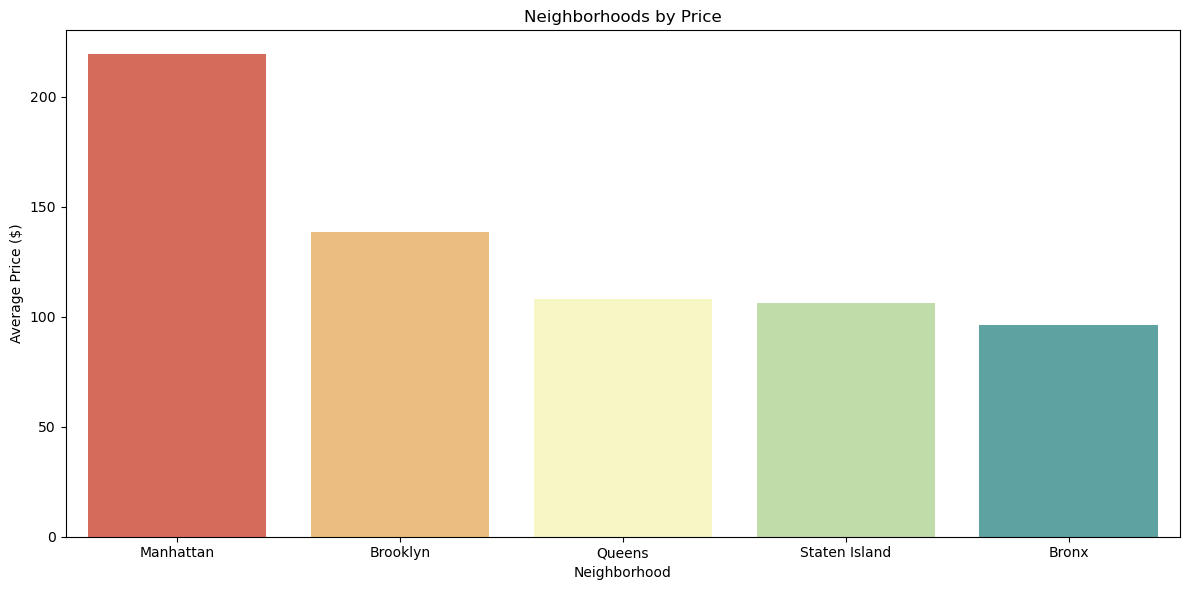

In [91]:
plt.figure(figsize=(12, 6))
sns.barplot(data=borough_pricing, x='neighbourhood_group_cleansed', y='avg_price', palette='Spectral', hue='neighbourhood_group_cleansed')
plt.title("Neighborhoods by Price")
plt.xlabel("Neighborhood")
plt.ylabel("Average Price ($)")
plt.tight_layout()
plt.show()

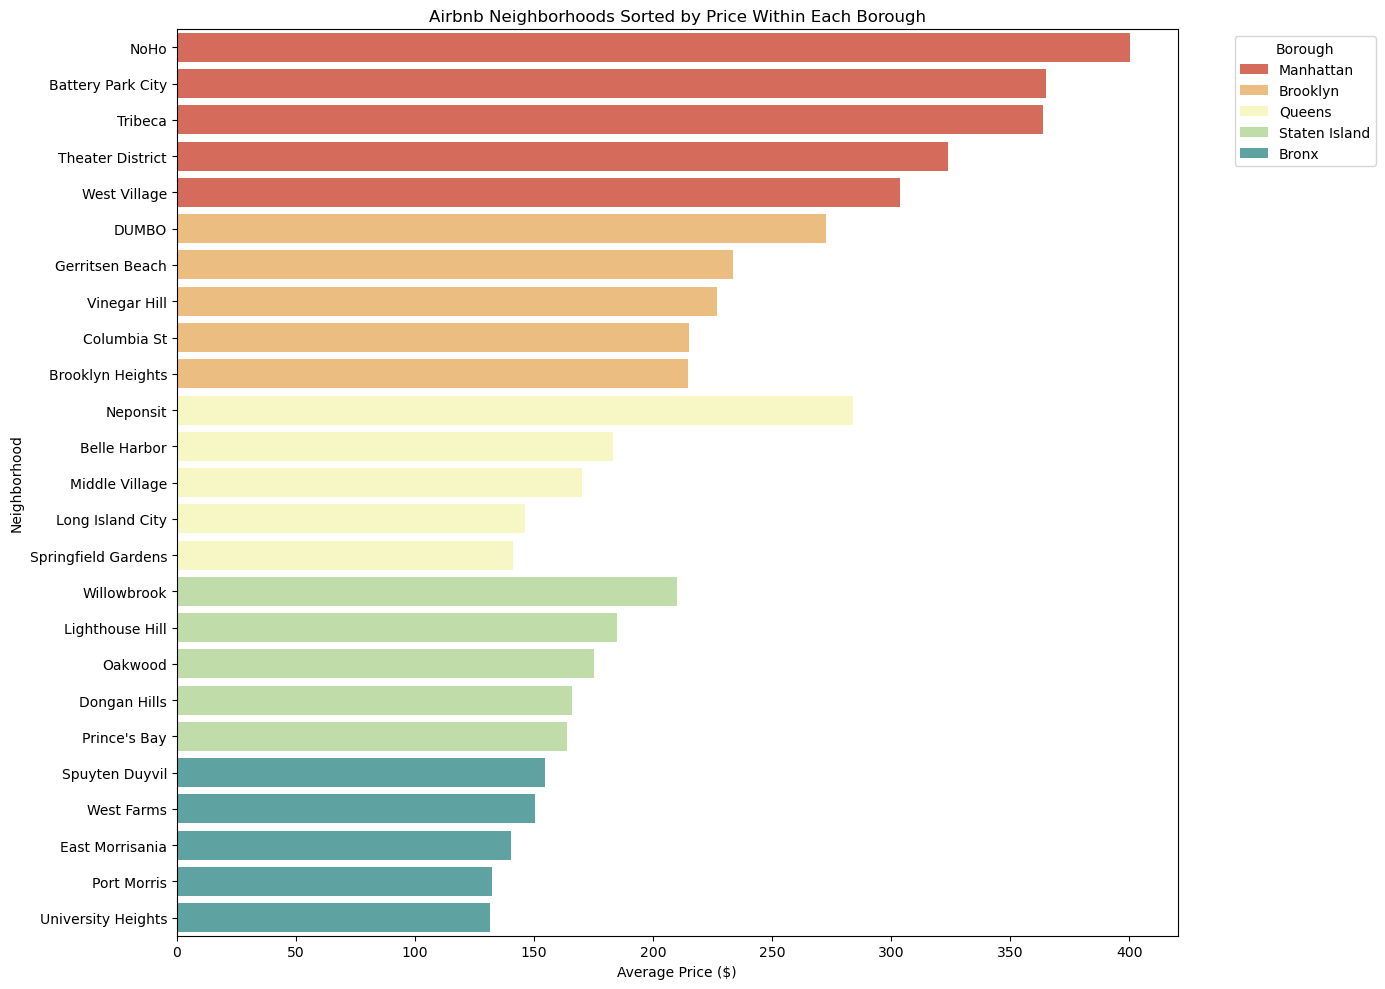

In [92]:
neighborhood_pricing_filtered = neighborhood_pricing[neighborhood_pricing['neighborhood_rank'] <= 5]

plt.figure(figsize=(14, 10))
sns.barplot(
    data=neighborhood_pricing_filtered,
    x='avg_price',
    y='neighbourhood_cleansed',
    hue='neighbourhood_group_cleansed',
    dodge=False,
    palette='Spectral'
)

plt.title("Airbnb Neighborhoods Sorted by Price Within Each Borough")
plt.xlabel("Average Price ($)")
plt.ylabel("Neighborhood")
plt.legend(title='Borough', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


The results here show a clear distinction between costs in different neighborhoods which make sense from a big picture point of view. Manhattan drives a substantial premium, followed by Brooklyn than other neighborhoods.

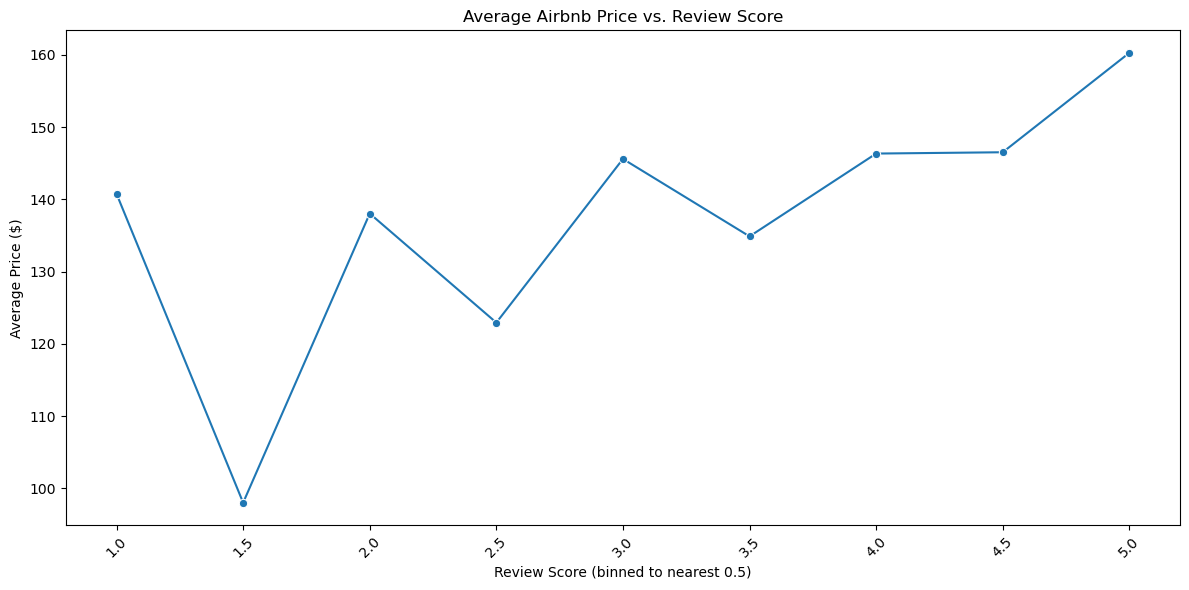

In [93]:
df = price_by_rating
df['rating_bin'] = (df['review_scores_rating'] * 2).round() / 2
df_grp = df.groupby(['rating_bin'])['price'].mean().reset_index()

# Plot the lineplot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_grp,
    x='rating_bin',
    y='price',
    marker='o'
)

plt.title("Average Airbnb Price vs. Review Score")
plt.xlabel("Review Score (binned to nearest 0.5)")
plt.ylabel("Average Price ($)")
plt.xticks(np.arange(1, 5.5, 0.5), rotation=45)
plt.tight_layout()
plt.show()

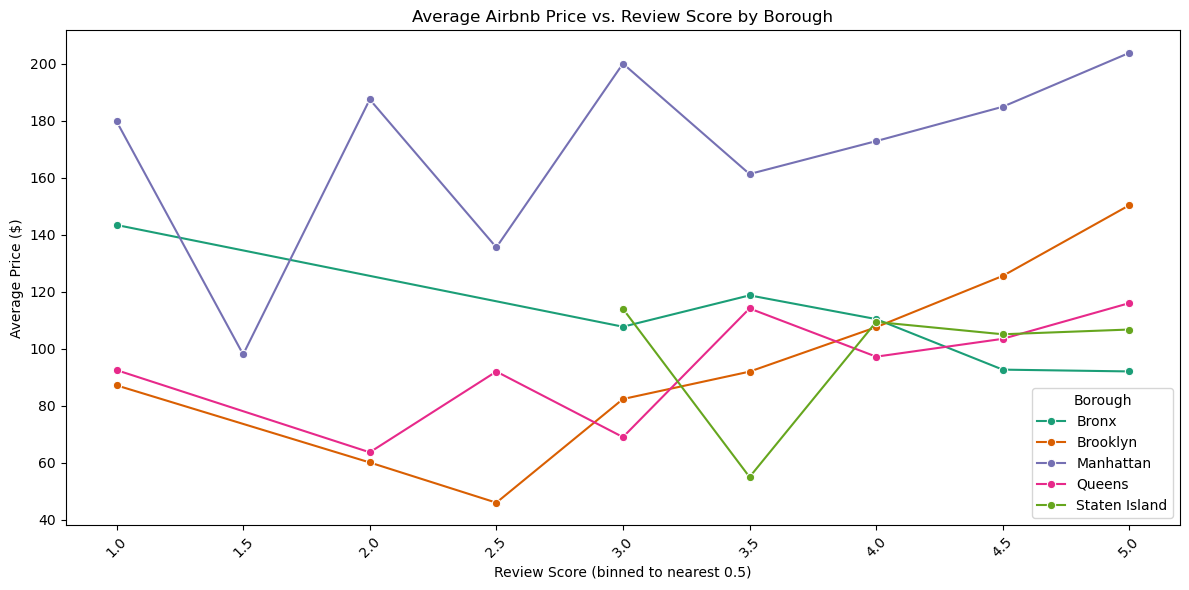

In [94]:
df = price_by_rating_by_neighborhood
df['rating_bin'] = (df['review_scores_rating'] * 2).round() / 2
df_grp = df.groupby(['neighbourhood_group_cleansed','rating_bin'])['price'].mean().reset_index()

# Plot the lineplot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_grp,
    x='rating_bin',
    y='price',
    hue='neighbourhood_group_cleansed',
    marker='o',
    palette='Dark2'
)

plt.title("Average Airbnb Price vs. Review Score by Borough")
plt.xlabel("Review Score (binned to nearest 0.5)")
plt.ylabel("Average Price ($)")
plt.xticks(np.arange(1, 5.5, 0.5), rotation=45)
plt.legend(title='Borough')
plt.tight_layout()
plt.show()


While the aggregate data checks out for this analysis, the per borough data does not work as well, probably due to lack of data.

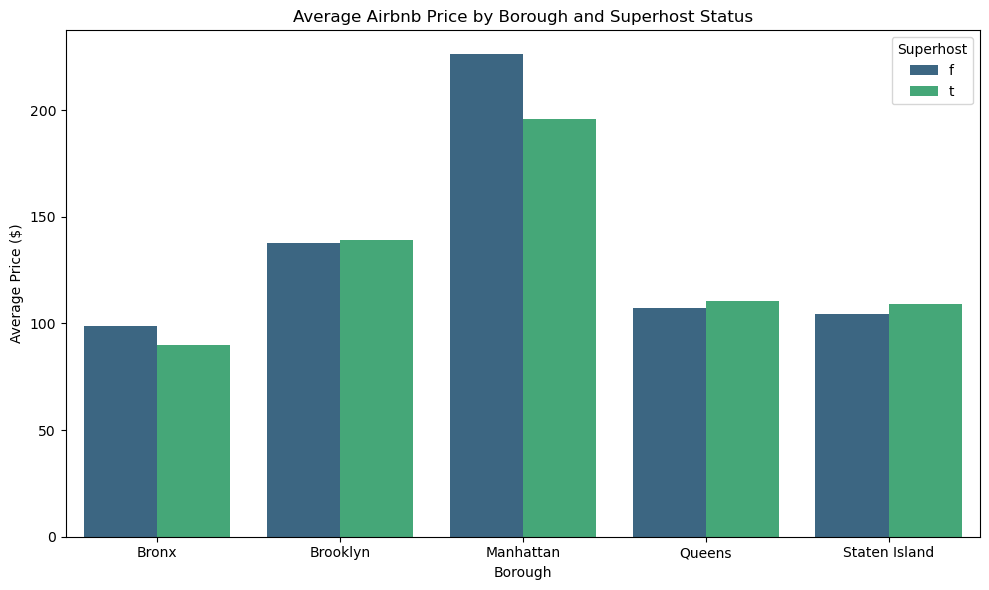

In [95]:
plt.figure(figsize=(10, 6))

sns.barplot(
    data=superhost_neighborhood_impact,
    x='neighbourhood_group_cleansed',
    y='avg_price',
    hue='host_is_superhost',
    palette='viridis'
)

plt.title("Average Airbnb Price by Borough and Superhost Status")
plt.xlabel("Borough")
plt.ylabel("Average Price ($)")
plt.legend(title="Superhost")
plt.tight_layout()
plt.show()


Finally, there seems to be a lack of correlation between superhost status and increased pricing. This graph even shows the inverse relationship for a few of the boroughs.

## Conclusion

This project demonstrates a simple data ingestion pipeline with analysis for a static set of Airbnb data. The insights we gained were expected (such as Manhattan being the most expensive) while some of the results were inconclusive and could be explored with more data/complex analysis. Overall, this serves as practice for me as I attempt more complex projects.